## Imports

In [2]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

In [21]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape to flat
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## Pipeline

In [22]:
# SVD
out_dimm = 12
svd = TruncatedSVD(n_components=out_dimm*out_dimm)

def svd_fit():
    svd.fit(x_train_flat)

start_time = time.time()
svd_fit()
svd_train_time = time.time() - start_time

x_train_flat_cut = svd.transform(x_train_flat)
x_test_flat_cut = svd.transform(x_test_flat)
x_train_flat_cut.shape

(60000, 144)

In [28]:
# AE
latent_dim = 16
inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(latent_dim, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

def ae_fit():
    autoencoder.fit(x_train_flat, x_train_flat_cut, epochs=10)

start_time = time.time()
ae_fit()
AE_train_time = time.time() - start_time

x_train_flat_cut = autoencoder.predict(x_train_flat)
print(x_train_flat_cut.shape)
x_test_flat_cut = autoencoder.predict(x_test_flat)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0319
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0204
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0186
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0171
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0162
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0156
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0152
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0148
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0146
Epoch 10/10
1875/1875 [==============================] - 2s 876us/step
(60000, 784)
313/313 [==============================] - 0s 946us/step


In [23]:
# SVD
svd = TruncatedSVD(n_components=676)

def svd_fit():
    svd.fit(x_train_flat_cut)

start_time = time.time()
svd_fit()
svd_train_time = time.time() - start_time

x_train_transformed = svd.transform(x_train_flat_cut)
print(x_train_transformed.shape)
x_test_transformed = svd.transform(x_test_flat_cut)

(60000, 676)


In [ ]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

## evaluation on MLPClassifier

### functions

In [3]:
def make_mlp_model(x_train, y_train):
    mlp_model = MLPClassifier(solver='lbfgs')
    mlp_model.fit(x_train, y_train)
    return mlp_model

In [28]:
def my_score(mlp_model1, x_test):
    y_pred = mlp_model1.predict(x_test)

    print("classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матриця помилок')
    plt.xlabel('Передбачений клас')
    plt.ylabel('Справжній клас')
    plt.show()

### Performance evaluation - original data

In [7]:
start_time = time.time()
mlp_model = make_mlp_model(x_train_flat, y_train)
print(f"Час навчання mlp на оригінальних даних - {time.time() - start_time}")

Час навчання mlp на оригінальних даних - 30.70292353630066


Класифікаційний звіт для оригінальних даних:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.97      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



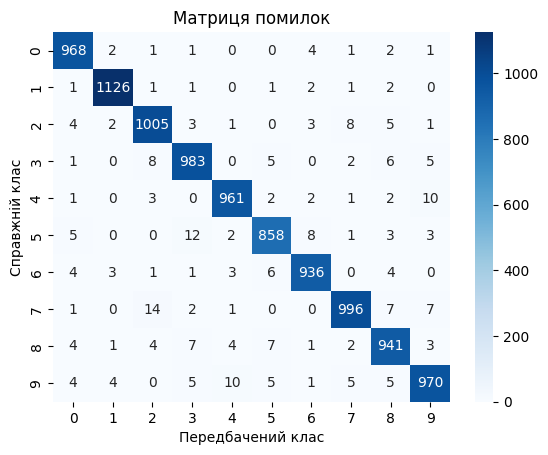

In [8]:
my_score(mlp_model, x_test_flat)

### Performance evaluation - reduced data

In [26]:
start_time = time.time()
mlp_model = make_mlp_model(x_train_flat_cut, y_train)
print(f"Час навчання mlp на редукованих даних - {time.time() - start_time}")

Час навчання mlp на редукованих даних - 18.99256658554077


classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



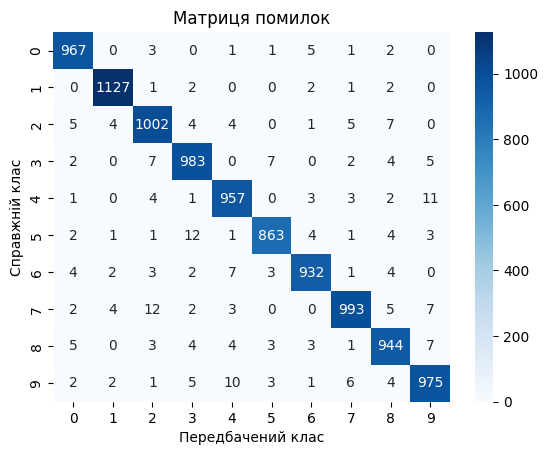

In [29]:
my_score(mlp_model, x_test_flat_cut)

# visualisation

In [23]:
X_recovered = svd.inverse_transform(x_train_flat_cut)
xx = np.reshape(X_recovered, (len(X_recovered), 28, 28))
xx.shape

(60000, 28, 28)

In [24]:
xx2 = np.reshape(x_train_flat_cut, (len(x_train_flat_cut), out_dimm, out_dimm))
xx2.shape

(60000, 12, 12)

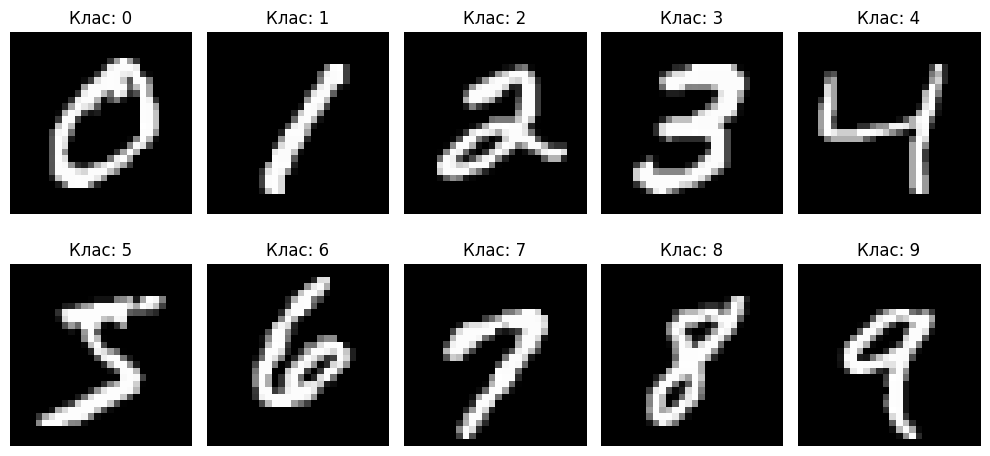

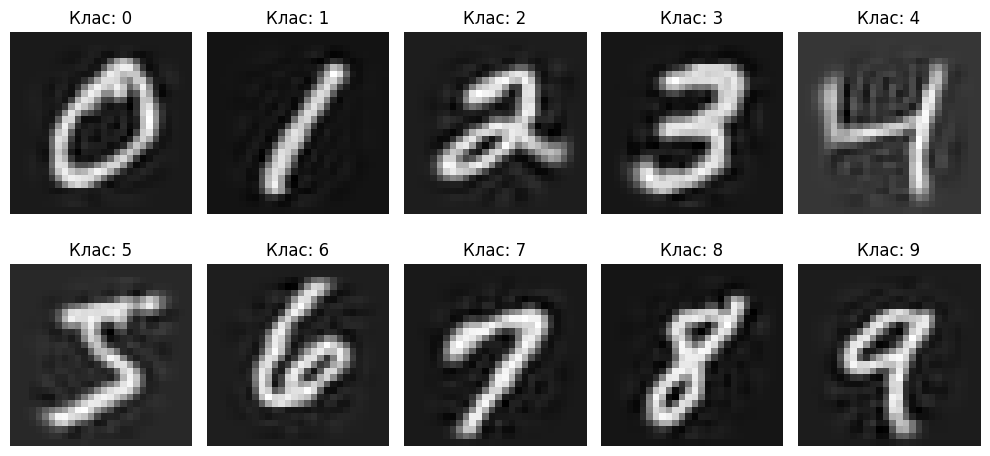

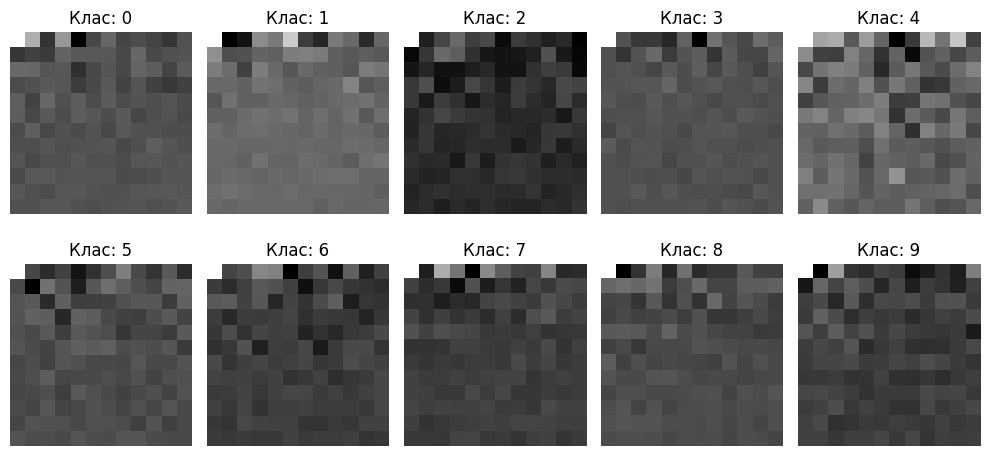

In [25]:
def plot_classes(x,y):
    unique_classes = np.unique(y)
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]
        
        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]
            
        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_classes(x_train,y_train)
plot_classes(xx,y_train)
plot_classes(xx2,y_train)

# TODO 
- read: https://www.kaggle.com/code/jonathankristanto/experimenting-with-pca-on-mnist-dataset
- як впливає автоенкодер
- доп. алгоритими до пайплайну
- функція оцінки ресурсів
- дослідити для яких алгоритмів (дерева рішень, класифікація) ми отримаємо перевагу від редукції